#### Loading the images

In [168]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
from skimage.feature import hog
from scipy.ndimage.measurements import label
%matplotlib inline


In [115]:
#----------------------------------------------
# Get Spatial binning return 32*32 features
#----------------------------------------------

def spatial_bin_feat(img,color_space = 'RGB',size = (32,32)):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
        elif color_space == 'HLS':
            feature_img = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
            feature_img = feature_img[:,:,1]
#             plt.title(feature_img[:,:,1].shape)
#             plt.imshow(feature_img[:,:,1],cmap = 'gray')
    else:
        feature_img = np.copy(img)
#     print(feature_img.shape)
    features = cv2.resize(feature_img,size).ravel()
   # print(features.shape)
    return features

#----------------------------------------------
# Get Color histogram features
#----------------------------------------------
def color_hist(img,nbins =32,bins_range = (0,256)):
    # histogram if RGB channels
    rhist = np.histogram(img[:,:,0],bins = nbins,range = bins_range)
    ghist = np.histogram(img[:,:,1],bins = nbins,range = bins_range)
    bhist = np.histogram(img[:,:,2],bins = nbins,range = bins_range)
    
    h_features = np.concatenate((rhist[0],ghist[0],bhist[0]))
    return h_features

#----------------------------------------------
# Get HOG features
#----------------------------------------------
def hog_features(img,orient,pix_per_cell,cell_per_block,vis = False ,feature_vec = True):
    ret_list = hog(img,orientations = orient ,pixels_per_cell = (pix_per_cell,pix_per_cell),cells_per_block = (cell_per_block,cell_per_block),block_norm= 'L2-Hys', transform_sqrt=False, visualise= vis, feature_vector= feature_vec)
    # name returns explicitly
    hog_features = ret_list[0]
    if vis:
        hog_image = ret_list[1]
        return hog_features.ravel(), hog_image
    else:
        return hog_features.ravel()
    
#----------------------------------------------
# Get Combined features
#----------------------------------------------
def get_all_features(t_img):
    sb_features = spatial_bin_feat(t_img,'HLS')
    # print(sb_features.size)# 1024
    hist_features = color_hist(t_img)
    # print(hist_features.size) # 96
    gray = cv2.cvtColor(t_img,cv2.COLOR_RGB2GRAY)
    h_features, hog_image = hog_features(gray, orient= 9, 
                            pix_per_cell= 8, cell_per_block= 2, 
                            vis=True, feature_vec=False)

    # print(hog_features.size) #1764
    # print(hog_features.shape) #(1764,)
    comb_feature = np.concatenate((sb_features,hist_features,h_features))
#     print(comb_feature)
    return comb_feature

In [116]:
non_vehicle_paths = ["non-vehicles/Extras/*.png", "non-vehicles/GTI/*.png"]

vehicle_paths = ["vehicles/GTI_Far/*.png", "vehicles/GTI_Left/*.png", "vehicles/GTI_Right/*.png",
                    "vehicles/GTI_MiddleClose/*.png", "vehicles/KITTI_extracted/*.png"]

non_vehicle_filenames = []
vehicle_filenames = []

for path in non_vehicle_paths:
    non_vehicle_filenames += glob.glob(path)
    
for path in vehicle_paths:
    vehicle_filenames += glob.glob(path)
    
# print(non_vehicle_filenames[0])
# print(vehicle_filenames[0])

In [4]:
# print("#Vehicles :",len(vehicle_filenames),"#Non-Vehicles:",len(non_vehicle_filenames))
# ## #Vehicles : 8792 #Non-Vehicles: 8968

# nv_img = plt.imread(non_vehicle_filenames[10])
# v_img = plt.imread(vehicle_filenames[10])
# plt.subplot(1,2,1)
# plt.title("Non vehicle")
# plt.imshow(nv_img)
# plt.subplot(1,2,2)
# plt.title("Vehicle")
# plt.imshow(v_img)

In [117]:
# print(np.max(nv_img),np.min(nv_img)) #0.8117647 0.015686275
# print(v_img.shape) #(64, 64, 3)
all_img_features = []
for idx in range(len(vehicle_filenames)):
    # to get all the feature
    v_img = cv2.imread(vehicle_filenames[idx])
    v_img = cv2.cvtColor(v_img,cv2.COLOR_BGR2RGB)
    img_feature = get_all_features(v_img)
    img_feature = img_feature.tolist()
    all_img_features.append(img_feature)
# print(all_img_features.size)
print(len(all_img_features))

for nv_idx in range(len(non_vehicle_filenames)):
    # to get all the feature
    nv_img = cv2.imread(non_vehicle_filenames[nv_idx])
    nv_img = cv2.cvtColor(nv_img,cv2.COLOR_BGR2RGB)
    img_feature = get_all_features(nv_img)
    img_feature = img_feature.tolist()
    all_img_features.append(img_feature)
    
# one hot encoded vectors is_car = 1 if its a car
is_car = np.ones(len(vehicle_filenames))
is_car = is_car.tolist()
# print(len(is_car))
non_car = np.zeros(len(non_vehicle_filenames))
non_car = non_car.tolist()
is_car += non_car
print(len(is_car))

8792
17760


In [118]:
# writing feature vectors in pickle file
import pickle
output_f = open('features.pkl','wb')
output_h = open('onehot.pkl','wb')
pickle.dump(all_img_features,output_f)
pickle.dump(is_car,output_h)

In [119]:
import pickle
f_file = open('features.pkl','rb')
h_file = open('onehot.pkl','rb')
X_pkl = pickle.load(f_file)
Y_pkl = pickle.load(h_file)
# print(len(X_train)) #17760
# print(len(Y_train)) #17760
X = np.vstack(X_pkl).astype(np.float64)
y = np.hstack(Y_pkl)

In [120]:
#-----------------------------
# Training the SVN model
#-----------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC

def train_model(X,y):
    rand_state = np.random.randint(0,100)
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = rand_state)

    # fit a per column scalar
    X_scalar = StandardScaler().fit(X_train)
    #Apply the scalar  to X
    scaled_X_train = X_scalar.transform(X_train)
    scaled_X_test = X_scalar.transform(X_test)
    #print(scaled_X_test)

    svc = SVC(kernel = "rbf")
    svc.fit(scaled_X_train,y_train)
    return svc,X_scalar,scaled_X_train,scaled_X_test,y_test


In [121]:
import time
start_time = time.time()
svc,X_scalar,_,scaled_X_test,y_test = train_model(X,y)
print("--- %s seconds ---" % (time.time() - start_time))
# print("Train Accuracy :",svc.score(scaled_X_train,y_train))
# # Linear SVC
# # Train Accuracy : 0.9985923423423423
# # SVC with linear kernel
# # Train Accuracy : 0.9995777027027027
# # SVC with rbf kernel
# # Train Accuracy : 0.9773367117117117
print("Test Accuracy :",svc.score(scaled_X_test,y_test))
# Linear SVC
# Test Accuracy : 0.9293355855855856
# SVC with linear kernel
# Test Accuracy : 0.928490990990991
# SVC with rbf kernel
# Test Accuracy : 0.9710022522522522

--- 134.0960168838501 seconds ---
Test Accuracy : 0.9881756756756757


In [ ]:
# #-----------------------------------
# #   Predicting (for Y=Testing)
# #-----------------------------------
# # print(len(scaled_X_test[0]))
# t1 = time.time()
# svc.predict(scaled_X_test[0:200])
# print(time.time()- t1) #2.0156702995300293


# # ridx = np.random.randint(0,len(vehicle_filenames))
# ridx = np.random.randint(0,len(non_vehicle_filenames))
# print(ridx,len(vehicle_filenames))
# # pred_img = plt.imread(vehicle_filenames[ridx])
# pred_img = plt.imread(non_vehicle_filenames[ridx])
# img_feat = get_all_features(pred_img)
# scaled_img_feat = X_scalar.transform(img_feat.reshape(1,-1))

# p_start_time = time.time()
# ret = svc.predict(scaled_img_feat)
# print("--- %s seconds ---" % (time.time() - p_start_time))
# print(ret)
# # for false images

# if ret == 1.0:
#     plt.imshow( plt.imread(non_vehicle_filenames[ridx]),cmap = 'gray')#4534 

In [ ]:
# a = np.array([1,23,44])
# a = a.tolist()
# print(type(a))
# x = []
# t = [1,2]
# p = [1,3]
# x.append(t)
# x.append(p)
# print(x)

In [164]:
#--------------------------------------------------
# Windowing Functions
#--------------------------------------------------
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=1):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def all_windows(img):
    test_img = np.copy(img)
    x_start_stop=[400, 1280]
    y_start_stop=[400, 500]
    w1 = slide_window(test_img, x_start_stop, y_start_stop,xy_window=(64, 64), xy_overlap=(0.5, 0.5))
    y_start_stop=[380, 600]
    w1.extend(slide_window(test_img, x_start_stop, y_start_stop,xy_window=(150, 100), xy_overlap=(0.7, 0.5)))
    y_start_stop=[380, 620]
    w1.extend(slide_window(test_img, x_start_stop, y_start_stop,xy_window=(200, 160), xy_overlap=(0.8, 0.5)))
    y_start_stop=[380, 580]
    w1.extend(slide_window(test_img, x_start_stop, y_start_stop,xy_window=(230, 115), xy_overlap=(0.8, 0.7)))
    windows_img = draw_boxes(test_img,w1)
    plt.imshow(windows_img)
    return w1

# passed args source image,Classifier object,all windows
def search_window_obj(img,svc,windows):
    car_windows = []
    count = 0
    for window in windows:
        # Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        features = get_all_features(test_img)
        scaled_feature = X_scalar.transform(features.reshape(1,-1))
        # predict using classifier
        prediction = svc.predict(scaled_feature)
        
        if prediction == 1:
            count+=1
            car_windows.append(window)
    print('matched windows:',count)
    return car_windows

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels,thrshold):
    # Iterate through all detected cars
    nboxes = 0
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        if ((np.max(nonzerox) - np.min(nonzerox)) > thrshold[0]) & ((np.max(nonzeroy) - np.min(nonzeroy)) > thrshold[1]):
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
            nboxes+=1
    # Return the image
    print(nboxes)
    return img

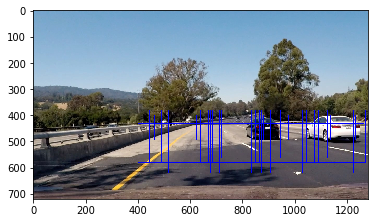

In [125]:
#-------------for plotting windows
test_img = plt.imread('./test_images/test4.jpg')
plt.imshow(test_img)
windows = all_windows(test_img)
windows_img = draw_boxes(test_img,windows)
# plt.imshow(windows_img)
plt.imsave('windows.jpg',windows_img)

In [169]:
def pipeline(frame_img):
    windows = all_windows(frame_img)
    hot_window = search_window_obj(frame_img,svc,windows)
    print(len(hot_window))
    # windows_img = draw_boxes(frame_img,hot_window)
    #plt.imsave('detected.jpg',windows_img)

    heat = np.zeros_like(frame_img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,hot_window)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    # print(type(labels))

    # to remove false positives
    heat_thrshold = [30,30]
    draw_img = draw_labeled_bboxes(np.copy(frame_img), labels ,heat_thrshold)
    return draw_img

matched windows: 23
23
2


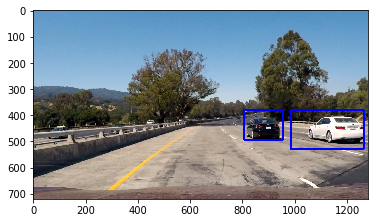

In [171]:
# pipeline testing
f_img = plt.imread('./test_images/test1.jpg')
ret_img = pipeline(f_img)
plt.imshow(ret_img)

matched windows: 36
36
1


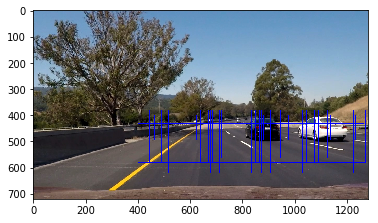

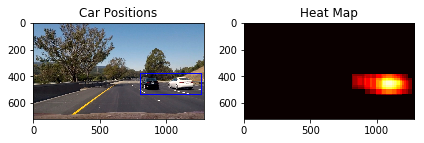

In [167]:
#---- for testing
from scipy.ndimage.measurements import label
frame_img = plt.imread('./test_images/test6.jpg')
windows = all_windows(frame_img)
hot_window = search_window_obj(frame_img,svc,windows)
print(len(hot_window))
# windows_img = draw_boxes(frame_img,hot_window)
#plt.imsave('detected.jpg',windows_img)

heat = np.zeros_like(frame_img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,hot_window)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
# print(type(labels))

# to remove false positives
heat_thrshold = [30,30]
draw_img = draw_labeled_bboxes(np.copy(frame_img), labels ,heat_thrshold)
fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.imsave('car_position.jpg',draw_img)
plt.imsave('heatmap.jpg',heatmap)